In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

In [4]:
# load the data

In [6]:
xcf_flavordb_tb=pd.read_csv('~/final_flavour/june_datasets/(14.09)xcf_tb_flavordb.csv',index_col=0,converters={'flavordb_ingrs':eval})
ars_flavordb_tb=pd.read_csv('~/final_flavour/june_datasets/(23.09)ars_tb_flavordb.csv',index_col=0,converters={'flavordb_ingr':eval})
kb_flavordb_tb=pd.read_csv('~/final_flavour/june_datasets/(09.07)kb_tb_flavordb.csv',index_col=0,converters={'flavordb_ingr':eval})

In [7]:
xcf_flavordb_tb.rename(columns={'flavordb_ingrs':'flavordb_ingr'},inplace=True)

In [8]:
print(xcf_flavordb_tb.shape)
print(ars_flavordb_tb.shape)
print(kb_flavordb_tb.shape)

(2366, 3)
(2133, 3)
(1864, 3)


In [9]:
xcf_flavordb_tb.head()

,recipe_id,flavordb_ingr,class
0,100000175,"[rice, salt, cabbage, oats, pepper]",1
1,100000387,"[salt, broccoli, cooking_oil, pork]",1
2,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...",1
3,100000444,"[shiitake, garlic, salt, cabbage, soybean_sauc...",1
4,100000562,"[durian, water]",1


In [10]:
ars_flavordb_tb.head()

,class,recipe_id,flavordb_ingr
0,0,152,"[butter, buttermilk, cooking_oil, egg, flour, ..."
1,0,198,"[biscuit, butter, codfish, lemon, onion, parsl..."
2,0,313,"[apple, butter, capsicum, cheddar_cheese, egg,..."
3,0,382,"[beef, carrot, celery, garlic, kale, kidney_be..."
4,0,596,"[biscuit, chocolate, cream_cheese, egg, sugar,..."


In [11]:
kb_flavordb_tb.head()

,class,recipe_id,flavordb_ingr
0,0,731,"[asparagus, butter, capsicum, chive, cooking_o..."
1,0,964,"[cocoa_powder, cream, egg, red_wine, sugar]"
2,0,1182,"[butter, egg, flour, milk, salt, spelt, sugar]"
3,0,1603,"[chive, onion, parsley, rosemary, water]"
4,0,1680,"[butter, egg, gelatin, lemon, milk, pudding, s..."


In [12]:
# define function for getting word2vec embeddings

In [16]:
from gensim.models import word2vec

In [17]:
def tt_w2v_transformer(data,col1,col2):
    
    # split train test datasets
    train_df,test_df,train_y,test_y=train_test_split(data[col1],data[col2],test_size=0.3,random_state=929)
    train_df=pd.DataFrame(train_df)
    test_df=pd.DataFrame(test_df)
    
    # build the train corpus
    train_corpus=train_df[col1].values.tolist()
    
    # train word2vec 
    num_features=100     
    min_word_count=1  
    num_workers=2
    downsampling = 1e-3
    window=2

    model=word2vec.Word2Vec(train_corpus,workers=num_workers,
                   vector_size=num_features,min_count=min_word_count,window=window,
                   sg=0,sample = downsampling)
    return model,train_df,test_df,train_y,test_y

In [18]:
def get_w2v_features(sentence,model):
        # model_vocabs=set(model.wv.vocab.keys())
        model_vocabs=set(model.wv.key_to_index.keys())
        featureVec = np.zeros(model.vector_size, dtype="float32")

        nwords=0
        for word in sentence:
            if word in model_vocabs:
                # featureVec=np.add(featureVec,model[word])
                featureVec=np.add(featureVec,model.wv[word])
                nwords+=1
            else:
                featureVec=featureVec
        if nwords > 0:
            #print(nwords)
            featureVec=np.divide(featureVec,nwords)
        return featureVec

In [19]:
# xcf_model.wv.most_similar('chicken')

In [20]:
xcf_model,xcf_train_df,xcf_test_df,xcf_train_y,xcf_test_y=tt_w2v_transformer(xcf_flavordb_tb,'flavordb_ingr','class')

In [21]:
xcf_train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,xcf_model),xcf_train_df['flavordb_ingr']))
xcf_test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,xcf_model),xcf_test_df['flavordb_ingr']))

In [22]:
xcf_train_X=np.array(list(map(np.array,xcf_train_df['w2v_features'])))
xcf_test_X=np.array(list(map(np.array,xcf_test_df['w2v_features'])))

In [23]:
ars_model,ars_train_df,ars_test_df,ars_train_y,ars_test_y=tt_w2v_transformer(ars_flavordb_tb,'flavordb_ingr','class')

In [24]:
ars_train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,ars_model),ars_train_df['flavordb_ingr']))
ars_test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,ars_model),ars_test_df['flavordb_ingr']))

In [25]:
ars_train_X=np.array(list(map(np.array,ars_train_df['w2v_features'])))
ars_test_X=np.array(list(map(np.array,ars_test_df['w2v_features'])))

In [26]:
kb_model,kb_train_df,kb_test_df,kb_train_y,kb_test_y=tt_w2v_transformer(kb_flavordb_tb,'flavordb_ingr','class')

In [27]:
kb_train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,kb_model),kb_train_df['flavordb_ingr']))
kb_test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,kb_model),kb_test_df['flavordb_ingr']))

In [28]:
kb_train_X=np.array(list(map(np.array,kb_train_df['w2v_features'])))
kb_test_X=np.array(list(map(np.array,kb_test_df['w2v_features'])))

In [27]:
# save the train test dataset

In [58]:
xcf_train_data=pd.concat([xcf_train_df,xcf_train_y],axis=1)
ars_train_data=pd.concat([ars_train_df,ars_train_y],axis=1)
kb_train_data=pd.concat([kb_train_df,kb_train_y],axis=1)

In [59]:
xcf_test_data=pd.concat([xcf_test_df,xcf_test_y],axis=1)
ars_test_data=pd.concat([ars_test_df,ars_test_y],axis=1)
kb_test_data=pd.concat([kb_test_df,kb_test_y],axis=1)

In [60]:
xcf_train_data.to_pickle('datasets/(30.06)xcf_train_w2v.pkl')
ars_train_data.to_pickle('datasets/(30.06)ars_train_w2v.pkl')
kb_train_data.to_pickle('datasets/(30.06)kb_train_w2v.pkl')

In [61]:
xcf_test_data.to_pickle('datasets/(30.06)xcf_test_w2v.pkl')
ars_test_data.to_pickle('datasets/(30.06)ars_test_w2v.pkl')
kb_test_data.to_pickle('datasets/(30.06)kb_test_w2v.pkl')

In [81]:
xcf_train_data=pd.read_pickle('datasets/xcf_train_w2v.pkl')
ars_train_data=pd.read_pickle('datasets/ars_train_w2v.pkl')
kb_train_data=pd.read_pickle('datasets/kb_train_w2v.pkl')

In [82]:
xcf_test_data=pd.read_pickle('datasets/xcf_test_w2v.pkl')
ars_test_data=pd.read_pickle('datasets/ars_test_w2v.pkl')
kb_test_data=pd.read_pickle('datasets/kb_test_w2v.pkl')

In [ ]:
# build classifiers

In [29]:
# NB
def NB_pipeline(train_X,test_X,train_y,test_y):
    nb = GaussianNB()
    cv=ShuffleSplit(n_splits=10,test_size=0.3,random_state=9527)
    nb_cv_results=cross_val_score(nb,train_X,train_y,cv=cv)
    nb.fit(train_X,train_y)
    y_pred=nb.predict(test_X)
    print('Mean Accuracy: %0.2f (+/- %0.2f)' % (nb_cv_results.mean(), nb_cv_results.std() * 2))
    print('Accuracy on test set: %0.2f' % accuracy_score(y_pred,test_y))
    return y_pred

In [30]:
# logistic regression
def log_pipeline(train_X,test_X,train_y,test_y):
    clf=LogisticRegression(random_state=9527)
    param_distribs={'C':[0.1,1,10,100,1000],
                    'solver':['lbfgs','sag']}
    log_search=RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    log_search.fit(train_X,train_y)
    print('Best parameters:',log_search.best_params_)
    print('Best estimatro:',log_search.best_estimator_)
    print('Best score:',log_search.best_score_)
    log=log_search.best_estimator_
    y_pred=log.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [31]:
# random forest
def rf_pipeline(train_X,test_X,train_y,test_y):
    clf=RandomForestClassifier(random_state=42)
    param_distribs={'n_estimators':[int(x) for x in np.linspace(start = 300, stop = 500, num = 10)],
                    'max_features':['auto','sqrt','log2'],
                    'max_depth':[5,6,7,8,9,10],
                    'criterion':['gini','entropy']}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    rf=random_search.best_estimator_
    rf.fit(train_X,train_y)
    y_pred=rf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [32]:
# svm(linear kernel)
def lsvc_pipeline(train_X,test_X,train_y,test_y):
    clf=SVC(kernel='linear',random_state=42)
    param_distribs={'C':np.arange(2,10,2),
                   'gamma':np.arange(0.1,1,0.2)}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    clf=random_search.best_estimator_
    y_pred=clf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [33]:
xcf_nby_pred=NB_pipeline(xcf_train_X,xcf_test_X,xcf_train_y,xcf_test_y)

Mean Accuracy: 0.61 (+/- 0.03)
Accuracy on test set: 0.60


In [34]:
xcf_logy_pred=log_pipeline(xcf_train_X,xcf_test_X,xcf_train_y,xcf_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'lbfgs', 'C': 1000}
Best estimatro: LogisticRegression(C=1000, random_state=9527)
Best score: 0.6298165471553889
accuracy score:  0.6394366197183099


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [35]:
xcf_rfy_pred=rf_pipeline(xcf_train_X,xcf_test_X,xcf_train_y,xcf_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 344, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=8, n_estimators=344, random_state=42)
Best score: 0.6177501546973392
accuracy score:  0.643661971830986


In [36]:
ars_nby_pred=NB_pipeline(ars_train_X,ars_test_X,ars_train_y,ars_test_y)

Mean Accuracy: 0.58 (+/- 0.03)
Accuracy on test set: 0.58


In [37]:
ars_logy_pred=log_pipeline(ars_train_X,ars_test_X,ars_train_y,ars_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'lbfgs', 'C': 100}
Best estimatro: LogisticRegression(C=100, random_state=9527)
Best score: 0.6476644744225719
accuracy score:  0.6546875


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [38]:
ars_rfy_pred=rf_pipeline(ars_train_X,ars_test_X,ars_train_y,ars_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 411, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=8, max_features='auto', n_estimators=411,
                       random_state=42)
Best score: 0.6550358016655069
accuracy score:  0.66875


In [39]:
kb_nby_pred=NB_pipeline(kb_train_X,kb_test_X,kb_train_y,kb_test_y)

Mean Accuracy: 0.53 (+/- 0.04)
Accuracy on test set: 0.54


In [40]:
kb_logy_pred=log_pipeline(kb_train_X,kb_test_X,kb_train_y,kb_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'sag', 'C': 1000}
Best estimatro: LogisticRegression(C=1000, random_state=9527, solver='sag')
Best score: 0.595870910698497
accuracy score:  0.5678571428571428


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [41]:
kb_rfy_pred=rf_pipeline(kb_train_X,kb_test_X,kb_train_y,kb_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 411, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=411,
                       random_state=42)
Best score: 0.5966489832007074
accuracy score:  0.5375


In [42]:
# learning curve

In [43]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [44]:
xcf_rf=RandomForestClassifier(max_depth=8, n_estimators=344, random_state=42)
ars_rf=RandomForestClassifier(max_depth=8, max_features='auto', n_estimators=411,
                       random_state=42)
kb_log=LogisticRegression(C=1000, random_state=9527, solver='sag')

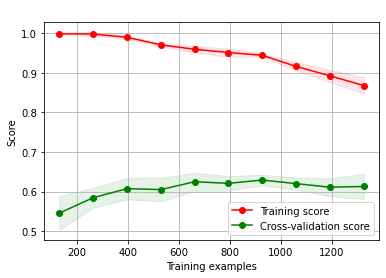

In [45]:
plot_cv_learning_curve(xcf_rf, ' ', xcf_train_X, xcf_train_y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))

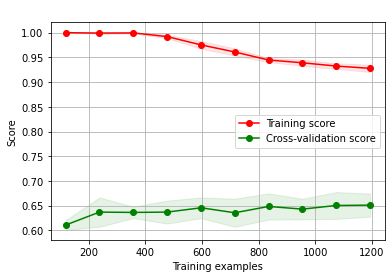

In [46]:
plot_cv_learning_curve(ars_rf, ' ', ars_train_X, ars_train_y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))

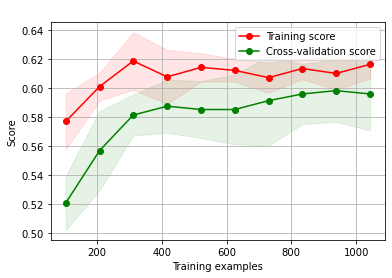

In [47]:
plot_cv_learning_curve(kb_log, ' ', kb_train_X, kb_train_y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))

In [ ]:
# import roc_auc score to see which classifier performe (slightly better)

In [51]:
from sklearn.metrics import roc_auc_score

In [52]:
print('AUC of NB based on Xiachufang dataset: ',roc_auc_score(xcf_nby_pred,xcf_test_y))
print('AUC of LOG based on Xiachufang dataset: ',roc_auc_score(xcf_logy_pred,xcf_test_y))
print('AUC of RF based on Xiachufang dataset: ',roc_auc_score(xcf_rfy_pred,xcf_test_y))
print('AUC of SVC based on Xiachufang dataset: ',roc_auc_score(xcf_svcy_pred,xcf_test_y))

AUC of NB based on Xiachufang dataset:  0.6115909090909091
AUC of LOG based on Xiachufang dataset:  0.6290997944047965
AUC of RF based on Xiachufang dataset:  0.6513631494684465
AUC of SVC based on Xiachufang dataset:  0.6559734513274336


In [53]:
print('AUC of NB based on Allrecipes dataset: ',roc_auc_score(ars_nby_pred,ars_test_y))
print('AUC of LOG based on Allrecipes dataset: ',roc_auc_score(ars_logy_pred,ars_test_y))
print('AUC of RF based on Allrecipes dataset: ',roc_auc_score(ars_rfy_pred,ars_test_y))
print('AUC of SVC based on Allrecipes dataset: ',roc_auc_score(ars_svcy_pred,ars_test_y))

AUC of NB based on Allrecipes dataset:  0.6081866750471402
AUC of LOG based on Allrecipes dataset:  0.6548668665138424
AUC of RF based on Allrecipes dataset:  0.647813436783636
AUC of SVC based on Allrecipes dataset:  0.6426461473539845


In [54]:
print('AUC of NB based on Kochbar dataset: ',roc_auc_score(kb_nby_pred,kb_test_y))
print('AUC of LOG based on Kochbar dataset: ',roc_auc_score(kb_logy_pred,kb_test_y))
print('AUC of RF based on Kochbar dataset: ',roc_auc_score(kb_rfy_pred,kb_test_y))
print('AUC of SVC based on Kochbar dataset: ',roc_auc_score(kb_svcy_pred,kb_test_y))

AUC of NB based on Kochbar dataset:  0.5206021087680355
AUC of LOG based on Kochbar dataset:  0.5857097288676236
AUC of RF based on Kochbar dataset:  0.5535584442091566
AUC of SVC based on Kochbar dataset:  0.5601383265856951


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
xcf_train_df.head()

,flavordb_ingr,w2v_features
723,"[salt, flour, butter, peach, pie_crust, water,...","[-0.06087961, 0.07330384, -0.05684248, 0.12900..."
999,"[egg, beer, canola_oil]","[-0.04172953, 0.046772975, -0.03576839, 0.0803..."
1065,"[garlic, eggplant, welsh_onion, soybean_sauce,...","[-0.05910874, 0.068569615, -0.048586093, 0.121..."
1030,"[vanilla, hazelnut, salt, cream, honey, egg, c...","[-0.062701076, 0.07513026, -0.05681557, 0.1336..."
788,"[soybean_sauce, garlic, shrimp, capsicum, cook...","[-0.07326646, 0.084850445, -0.064880885, 0.151..."


In [44]:
xcf_train_df.loc[0,'w2v_features']

array([-0.06765841,  0.07961685, -0.05917092,  0.13792123,  0.01042201,
       -0.09129458, -0.2191124 ,  0.09814113, -0.24579081, -0.082048  ,
        0.02440495, -0.14769192,  0.09173218,  0.17695877, -0.22708385,
        0.4443098 ,  0.2681414 , -0.00538251, -0.05702858,  0.09609137,
       -0.16315298,  0.18153279, -0.1744875 , -0.09496354,  0.15542403,
       -0.06373338,  0.13891527, -0.03969802, -0.15767102, -0.12308022,
       -0.00774467,  0.11542064,  0.18736407,  0.10383974,  0.00626309,
       -0.10985903,  0.04259089, -0.02319239, -0.07562727, -0.01737   ,
       -0.24246469, -0.16473608,  0.00477949, -0.0453767 , -0.00263665,
       -0.31051922,  0.08146849,  0.17168662,  0.00511611,  0.03011772,
       -0.04588606, -0.10351063, -0.38338965, -0.11751316, -0.14318956,
        0.01624472, -0.10169818,  0.03336211, -0.0383888 ,  0.23355138,
        0.20521975,  0.12260097, -0.18205734,  0.09008396,  0.04118161,
       -0.15125272, -0.16626829, -0.22790246,  0.08283948,  0.02

In [42]:
xcf_train_df.loc[4]

flavordb_ingr                                      [durian, water]
w2v_features     [-0.044597495, 0.052598044, -0.04269863, 0.091...
Name: 4, dtype: object

In [45]:
cosine_similarity(xcf_train_df.loc[0,'w2v_features'].reshape(1,-1),xcf_train_df.loc[4,'w2v_features'].reshape(1,-1))

array([[0.99975127]], dtype=float32)

In [17]:
xcf_temp_emb=pd.DataFrame(xcf_train_df['w2v_features'].tolist())

In [18]:
xcf_temp_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.060880,0.073304,-0.056842,0.129005,0.008589,-0.085631,-0.207444,0.090600,-0.228282,-0.075015,...,0.122794,-0.193790,-0.092486,0.079818,0.175683,0.224244,-0.135410,-0.117458,0.145860,0.183231
1,-0.041730,0.046773,-0.035768,0.080303,0.007177,-0.054332,-0.128903,0.058601,-0.143429,-0.046178,...,0.074561,-0.118142,-0.054963,0.048071,0.106960,0.134799,-0.082032,-0.073741,0.087833,0.113653
2,-0.059109,0.068570,-0.048586,0.121143,0.007760,-0.078435,-0.192190,0.083746,-0.210692,-0.069676,...,0.114092,-0.178414,-0.083598,0.074403,0.162125,0.208043,-0.123542,-0.110604,0.133303,0.167943
3,-0.062701,0.075130,-0.056816,0.133663,0.012524,-0.087763,-0.211677,0.093661,-0.231755,-0.078026,...,0.125251,-0.195527,-0.091397,0.082946,0.180656,0.227535,-0.136809,-0.119024,0.147643,0.184283
4,-0.073266,0.084850,-0.064881,0.151189,0.009529,-0.100580,-0.242371,0.107106,-0.269357,-0.089714,...,0.144263,-0.225894,-0.104775,0.093089,0.201744,0.261430,-0.156289,-0.138367,0.167930,0.210586


In [40]:
cosine_similarity(xcf_temp_emb.loc[0].values.reshape(1,-1),xcf_temp_emb.loc[1].values.reshape(1,-1))

array([[0.99976261]])

In [23]:
xcf_temp_cs_df=pd.DataFrame(cosine_similarity(xcf_temp_emb))

In [24]:
xcf_temp_cs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655
0,1.000000,0.999763,0.999903,0.999954,0.999924,0.999940,0.999965,0.999931,0.999879,0.999925,...,0.999945,0.999928,0.999956,0.999898,0.999961,0.999955,0.999916,0.999964,0.999429,0.999531
1,0.999763,1.000000,0.999792,0.999795,0.999767,0.999790,0.999795,0.999727,0.999636,0.999814,...,0.999750,0.999790,0.999775,0.999746,0.999778,0.999785,0.999742,0.999779,0.999189,0.999346
2,0.999903,0.999792,1.000000,0.999907,0.999953,0.999966,0.999897,0.999888,0.999802,0.999915,...,0.999889,0.999971,0.999908,0.999852,0.999884,0.999878,0.999888,0.999884,0.999350,0.999558
3,0.999954,0.999795,0.999907,1.000000,0.999906,0.999926,0.999952,0.999923,0.999858,0.999941,...,0.999922,0.999926,0.999968,0.999878,0.999946,0.999948,0.999897,0.999953,0.999351,0.999494
4,0.999924,0.999767,0.999953,0.999906,1.000000,0.999981,0.999908,0.999919,0.999842,0.999931,...,0.999899,0.999960,0.999915,0.999856,0.999901,0.999894,0.999921,0.999900,0.999445,0.999533


In [26]:
xcf_temp_cs_df=xcf_temp_cs_df.where(np.triu(np.ones(xcf_temp_cs_df.shape)).astype(np.bool))

In [28]:
xcf_temp_cs_df=pd.DataFrame(xcf_temp_cs_df.stack().reset_index())

In [30]:
xcf_temp_cs_df.columns=['recipe_1','recipe_2','cs']

In [32]:
xcf_temp_cs_df=xcf_temp_cs_df[xcf_temp_cs_df['recipe_1']!=xcf_temp_cs_df['recipe_2']]

In [33]:
xcf_temp_cs_df.head()

,recipe_1,recipe_2,cs
1,0,1,0.999763
2,0,2,0.999903
3,0,3,0.999954
4,0,4,0.999924
5,0,5,0.999940


<AxesSubplot:xlabel='cs'>

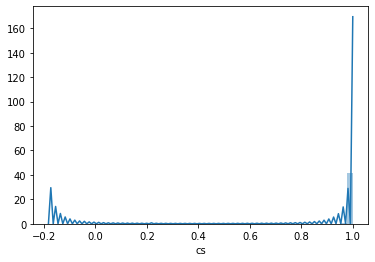

In [35]:
sns.distplot(xcf_temp_cs_df['cs'])